In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pipeline.ingest import behavior as behavior_ingest
from pipeline.ingest import ephys as ephys_ingest
from pipeline import lab, get_schema_name, experiment, foraging_analysis, report, ephys, histology, psth_foraging, ccf
import pipeline.shell as shell
shell.logsetup('INFO')
[hh for hh in dj.list_schemas() if 'hanhou' in hh]

Connecting hanhou@datajoint.mesoscale-activity-map.org:3306


['hanhou_foraging_ccf',
 'hanhou_foraging_ephys',
 'hanhou_foraging_experiment',
 'hanhou_foraging_foraging_analysis',
 'hanhou_foraging_foraging_model',
 'hanhou_foraging_histology',
 'hanhou_foraging_ingest_behavior',
 'hanhou_foraging_ingest_ephys',
 'hanhou_foraging_ingest_histology',
 'hanhou_foraging_lab',
 'hanhou_foraging_psth',
 'hanhou_foraging_psth_foraging',
 'hanhou_foraging_publication',
 'hanhou_foraging_report',
 'hanhou_foraging_tracking',
 'hanhou_test_schema']

# Basic structure of the public DB

The purpose here is to navigate through the tables for MAP phase 1 and see what I should prepare for the foraging task. <br>
To access the tables in the public DB, I have to find the correct schema and spawn the missing classes, like this.

In [ ]:
[public for public in dj.list_schemas() if 'map_v2' in public]

In [ ]:
public_lab = dj.schema('map_v2_lab'); public_lab.spawn_missing_classes()
public_ingest_ephys = dj.schema('map_v2_ingest_ephys'); public_ingest_ephys.spawn_missing_classes()
public_ephys =  dj.schema('map_v2_ephys'); public_ephys.spawn_missing_classes()

After doing this, query the public tables by directly calling the names `EphysIngest` or `WaterRestriction` instead of `ephys.EphysIngest` or `lab.WaterRestriction` (which are my private tables) <br>
Compare the two below:

In [ ]:
dj.ERD(public_lab)

In [ ]:
dj.ERD(lab)

In [ ]:
dj.ERD(public_ephys)

Let's see what's in the public `EphysIngest`

In [ ]:
EphysIngest() * EphysIngest.EphysFile() * WaterRestriction() & 'water_restriction_number = "SC050"'

In [ ]:
ProbeInsertion.InsertionNote()

In [ ]:
BrainArea()

In [ ]:
ProbeInsertion.RecordableBrainRegion()

In [ ]:
BrainAreaDepthCriteria()

In [ ]:
ProbeInsertionQuality()

# What do I have now?

In [ ]:
dj.ERD(ephys)

All probe insertions

In [ ]:
(ephys.ProbeInsertion() * experiment.Session()).fetch()

In [ ]:
ephys.ProbeInsertion().RecordableBrainRegion()

Sessions that have ephys

In [ ]:
experiment.Session & ephys.ProbeInsertion()

The number of ks2 units for each probe

In [ ]:
ephys.ProbeInsertion.aggr(ephys.Unit.proj(electrode_config_name_Unit='electrode_config_name'), n='count(*)')

In [ ]:
ephys.Unit()

In [ ]:
ephys.UnitStat()

# Add bitcode to my own pipeline

Check bitcode on public DB

In [ ]:
public_experiment = dj.schema('map_v2_experiment')
public_experiment.spawn_missing_classes()
dj.ERD(public_experiment)

In [ ]:
((TrialNote() & 'trial_note_type = "bitcode"') * WaterRestriction.proj('water_restriction_number') & 'water_restriction_number = "SC050" OR water_restriction_number = "DL011"') & 'session = 1' & 'trial = 1'

So obviously them have increased the length of bitcode from 10 to 20 at some point.

Now let me check whether my bitcodes have been correctly ingested. (note the module name `experiment` and `lab` here)

In [ ]:
(experiment.TrialNote() & 'trial_note_type = "bitcode"') * lab.WaterRestriction.proj('water_restriction_number') & 'trial = 1'

It makes sense that the session numbers don't start from 1 because I just introduced bitcode into my pybpod code recently.

In [ ]:
foraging_sessions = (experiment.Session & "username='HH'")  * lab.WaterRestriction().proj('water_restriction_number') & (experiment.BehaviorTrial & 'task in ("foraging")')
foraging_sessions

List all foraging sessions that have bitcode and also show some stats

In [ ]:
(experiment.Session * foraging_analysis.SessionStats.proj('session_total_trial_num', 'session_foraging_eff_optimal') 
 * lab.WaterRestriction().proj('water_restriction_number') & (experiment.TrialNote() & 'trial_note_type = "bitcode"')
).fetch(format='frame') 

# Ephys Ingestion

In [ ]:
dj.ERD(ephys) + dj.ERD(ephys_ingest)

## Prepare the electrodes!!!

In [ ]:
lab.ProbeType()

In [ ]:
for probe_type in lab.ProbeType.fetch():
    print(probe_type[0])
    lab.ProbeType.create_neuropixels_probe(probe_type=probe_type[0])

In [ ]:
lab.ProbeType.Electrode()

## Find the sessions that have ephys data ingested

In [ ]:
experiment.Session() * lab.WaterRestriction.proj('water_restriction_number') & ephys.ProbeInsertion() 

In [ ]:
from pipeline.ingest import ephys as ephys_ingest
ephys_ingest.EphysIngest.EphysFile & lab.WaterRestriction.proj('water_restriction_number') & ephys.ProbeInsertion() 

In [ ]:
ephys.ProbeInsertion() * experiment.Session() * lab.WaterRestriction.proj('water_restriction_number') 

To delete certain insertions

In [ ]:
ephys.ProbeInsertion().delete()

Should also delete ephys_ingest.EphysIngest() table!!

In [ ]:
ephys_ingest.EphysIngest().delete()

## Ingest ephys sessions

Ingest ephys

In [ ]:
shell.ingest_ephys()

Ingest ephys notes

In [ ]:
shell.load_insertion_location(dj.config.get('custom').get('recording_notes_spreadsheet'))

Check all meta data for `ephys.ProbeInsertion`

In [ ]:
ephys.ProbeInsertion * ephys.ProbeInsertion.InsertionLocation * ephys.ProbeInsertion.RecordableBrainRegion * ephys.ProbeInsertion.RecordingSystemSetup

Compute UnitStat (see `shell.populate_ephys`)

In [ ]:
populate_settings={'reserve_jobs': True, 'display_progress': True}
ephys.UnitStat.populate(**populate_settings)

Compute UnitCellType (see `shell.populate_ephys`)

In [ ]:
ephys.UnitCellType.populate(**populate_settings)

# QC

The one Dave showed (a little strigent for me now)

In [8]:
len((ephys.Unit * ephys.ClusterMetric * ephys.UnitStat * ephys.MAPClusterMetric.DriftMetric) & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70' & 'drift_metric < 0.1')

543

# Histology ingestion

## Preparation

In [2]:
from pipeline import ccf

In [ ]:
ccf.CCFBrainRegion.load_regions()
ccf.AnnotatedBrainSurface.load_matlab_mesh('Annotation_new_10_ds222_16bit_isosurf.mat')

In [ ]:
ccf.CCFAnnotation.load_ccf_annotation()

Total length in the main pipeline = 63265854

In [4]:
len(ccf.CCFAnnotation())

63265854

Finally done!!

## CCFAnnotation

Check histology

In [8]:
(experiment.Session & histology.ElectrodeCCFPosition) * (lab.WaterRestriction.proj('water_restriction_number'))

*subject_id    *session    session_date     session_time     username     rig           water_restriction_number    
+------------+ +---------+ +--------------+ +--------------+ +----------+ +-----------+ +--------------------------+
473361         46          2021-04-16       0:01:12          HH           Ephys-Han     HH09                        
473361         47          2021-04-18       23:00:03         HH           Ephys-Han     HH09                        
473361         48          2021-04-19       21:53:49         HH           Ephys-Han     HH09                        
473361         50          2021-04-29       17:58:45         HH           Ephys-Han     HH09                        
473361         57          2021-06-09       16:28:15         HH           Ephys-Han     HH09                        
473361         58          2021-06-11       15:32:12         HH           Ephys-Han     HH09                        
473361         59          2021-06-12       14:18:29         HH           Ephys-Han     HH09                        
473361         60          2021-06-13       20:27:10         HH           Ephys-Han     HH09                        
473361         61          2021-06-14       20:07:51         HH           Ephys-Han     HH09                        
 (Total: 9)

Do ingestion

In [ ]:
shell.ingest_histology()

Check all of the brains assigned to me (sessions that have histology)

In [9]:
my_assigned_brains = 'water_restriction_number in ("HH09")'
my_registered_sessions = experiment.Session * lab.WaterRestriction.proj('water_restriction_number') & histology.ElectrodeCCFPosition & my_assigned_brains

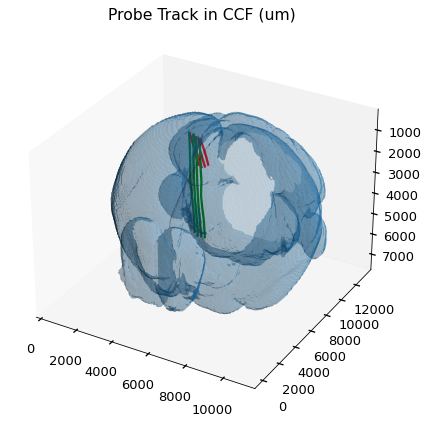

In [11]:
from pipeline.plot import histology_plot
histology_plot.plot_probe_tracks(my_registered_sessions);

Check insertions that do **NOT** have histology

In [12]:
my_assigned_brains = lab.WaterRestriction.proj('water_restriction_number') & 'water_restriction_number in ("HH09")'
my_assigned_insertions = ephys.ProbeInsertion * experiment.Session  * my_assigned_brains
print(f'All insertions assigned to me: {len(my_assigned_insertions)}')
my_assigned_insertions - histology.ElectrodeCCFPosition

All insertions assigned to me: 18


*subject_id    *session    *insertion_number    probe           probe_type               electrode_config_name     session_date     session_time     username     rig           water_restriction_number    
+------------+ +---------+ +------------------+ +-------------+ +----------------------+ +-----------------------+ +--------------+ +--------------+ +----------+ +-----------+ +--------------------------+
473361         42          1                    17131309211     neuropixels 1.0 - 3B     1-384                     2021-04-06       4:49:48          HH           Ephys-Han     HH09                        
473361         46          2                    18005123491     neuropixels 1.0 - 3B     1-384                     2021-04-16       0:01:12          HH           Ephys-Han     HH09                        
 (Total: 2)

Show all recorded areas

In [3]:
dj.U('annotation').aggr((ephys.Unit * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:30]

count
annotation                                         
Secondary motor area, layer 6a                  723
Anterior olfactory nucleus                      564
Mediodorsal nucleus of thalamus                 464
Secondary motor area, layer 5                   422
Orbital area, medial part, layer 5              417
Prelimbic area, layer 5                         396
Caudoputamen                                    391
Orbital area, ventrolateral part, layer 5       259
Posterior complex of the thalamus               238
Retrosplenial area, ventral part, layer 5       198
Taenia tecta, ventral part                      178
Nucleus accumbens                               164
Anterior cingulate area, dorsal part, layer 5   145
Midbrain reticular nucleus                      145
Dorsal peduncular area                          141
Substantia innominata                           131
Prelimbic area, layer 6a                        128
Taenia tecta, dorsal part                       122
Lateral preoptic area                           122
Orbital area, ventrolateral part, layer 2/3     121
Orbital area, lateral part, layer 5             119
Ventral medial nucleus of the thalamus          116
Central lateral nucleus of the thalamus         108
Field CA1                                        95
Submedial nucleus of the thalamus                89
Orbital area, medial part, layer 6a              86
Olfactory areas                                  83
Dentate gyrus, molecular layer                   83
Globus pallidus, external segment                79
medial lemniscus                                 68

After stringent QC

In [9]:
qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat * ephys.MAPClusterMetric.DriftMetric) & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70' & 'drift_metric < 0.1'
dj.U('annotation').aggr(((ephys.Unit & qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:30]

count
annotation                                         
Secondary motor area, layer 6a                   47
Anterior olfactory nucleus                       36
Mediodorsal nucleus of thalamus                  33
Secondary motor area, layer 5                    28
Dorsal peduncular area                           24
Caudoputamen                                     22
Orbital area, ventrolateral part, layer 5        21
Orbital area, ventrolateral part, layer 2/3      19
Retrosplenial area, ventral part, layer 5        18
Field CA1                                        15
Olfactory areas                                  14
Orbital area, lateral part, layer 5              13
Posterior complex of the thalamus                13
medial lemniscus                                 13
Orbital area, medial part, layer 5               13
Lateral preoptic area                            12
Globus pallidus, external segment                12
Substantia innominata                            11
Dentate gyrus, molecular layer                   11
Anterior cingulate area, dorsal part, layer 5    11
Submedial nucleus of the thalamus                11
Taenia tecta, dorsal part                        10
Prelimbic area, layer 5                           9
Anterior pretectal nucleus                        8
Taenia tecta, ventral part                        7
Nucleus accumbens                                 7
Midbrain reticular nucleus                        7
Hypothalamus                                      7
Central lateral nucleus of the thalamus           6
Retrosplenial area, ventral part, layer 1         6

# Ephys PSTH

## Previous pipeline

First, make sure the `psth_foraging.TrialCondition` have the correct conditions. <br> Note that I separate foraging ephys analysis to another new schema `psth_foraging`.

In [10]:
from pipeline import psth_foraging

In [11]:
psth_foraging.TrialCondition()

*trial_condition_name            trial_condition_hash                 trial_condition_func         trial_cond
+------------------------------+ +----------------------------------+ +--------------------------+ +--------+
foraging_LR_all_noearlylick      c1ed68f9625b5de968b8831c9e82a659     _get_trials_exclude_stim     =BLOB=    
foraging_LR_hit_noearlylick      ad875075498842aab833752d4fc5dc9f     _get_trials_exclude_stim     =BLOB=    
foraging_LR_miss_noearlylick     009703e23db2b60b0a62faada17d33dc     _get_trials_exclude_stim     =BLOB=    
foraging_L_all_noearlylick       1aef3cc13729a98fa71e6800f8fd59d8     _get_trials_exclude_stim     =BLOB=    
foraging_L_hit_noearlylick       caa4861706638bf200f1e90eda5ea428     _get_trials_exclude_stim     =BLOB=    
foraging_L_miss_noearlylick      e7ff1aea5c2f3eb1f9828cf0ba3b9ca8     _get_trials_exclude_stim     =BLOB=    
foraging_R_all_noearlylick       0a67e26a0a8083f83813ed95ca0731f4     _get_trials_exclude_stim     =BLOB=    
foraging_R_hit_noearlylick       911adc826d490eee4117638317ba51df     _get_trials_exclude_stim     =BLOB=    
foraging_R_miss_noearlylick      5d70dce8a7413fbd285fb28924f6ba3f     _get_trials_exclude_stim     =BLOB=    
 (Total: 9)

In [14]:
psth_foraging.TrialCondition.get_trials('foraging_L_hit_noearlylick').fetch(format='frame', limit=10)

task  task_protocol trial_instruction  \
subject_id session trial                                              
447921     1       8      foraging            100              none   
                   20     foraging            100              none   
                   22     foraging            100              none   
                   36     foraging            100              none   
                   49     foraging            100              none   
                   52     foraging            100              none   
                   72     foraging            100              none   
                   99     foraging            100              none   
                   102    foraging            100              none   
                   113    foraging            100              none   

                         early_lick outcome  auto_water  free_water water_port  
subject_id session trial                                                        
447921     1       8       no early     hit           0           0       left  
                   20      no early     hit           0           0       left  
                   22      no early     hit           0           0       left  
                   36      no early     hit           0           0       left  
                   49      no early     hit           0           0       left  
                   52      no early     hit           0           0       left  
                   72      no early     hit           0           0       left  
                   99      no early     hit           0           0       left  
                   102     no early     hit           0           0       left  
                   113     no early     hit           0           0       left

Here I need to run `foraging_populate.py` to do parallel population of `psth_foraging.UnitPsth`

Check progress of populating PSTH

In [ ]:
schema = dj.schema(get_schema_name('psth_foraging'))
schema.jobs

In [ ]:
schema.jobs.fetch('key')

In [ ]:
length = len(psth_foraging.UnitPsth())
ratio = length / len(psth_foraging.UnitPsth.key_source)
print(f'ephys.Unit:{length}, {ratio:.2%}')

In [ ]:
schema.jobs.delete()

In [ ]:
dj.kill()

After populating PSTH (with some bug fixes), single unit PSTH can be plotted

In [17]:
experiment.Session & 'session_date = "2021-04-29"'

*subject_id    *session    session_date     session_time     username     rig                 
+------------+ +---------+ +--------------+ +--------------+ +----------+ +------------------+
473359         28          2021-04-29       19:47:38         HH           Training-Tower-3    
473361         50          2021-04-29       17:58:45         HH           Ephys-Han           
482350         41          2021-04-29       19:51:35         HH           Ephys-Han           
482354         41          2021-04-29       19:42:30         HH           Training-Tower-1    
 (Total: 4)

In [21]:
from pipeline.plot import unit_psth

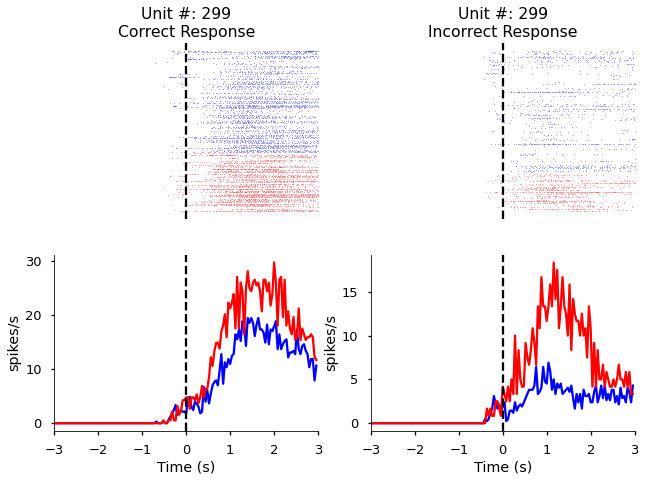

In [25]:
unit = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-29"') & 'insertion_number=1' & 'unit_uid=299').fetch1("KEY")
_ = unit_psth.plot_unit_psth_foraging(unit)

## New flexible PSTHs

In [3]:
from pipeline import psth_foraging
from pipeline.plot import unit_psth

In [9]:
date, imec, unit = '2021-04-29', 0, 501
unit_key = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-18"' & 'subject_id = 473361') & {'insertion_number': imec + 1, 'unit_uid': unit}).fetch1("KEY")

### PSTH grouped by choice and outcome

In [70]:
align_types=['trial_start', 'go_cue', 'first_lick_after_go_cue', 'iti_start', 'next_trial_start', 'next_two_trial_start']

In [ ]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

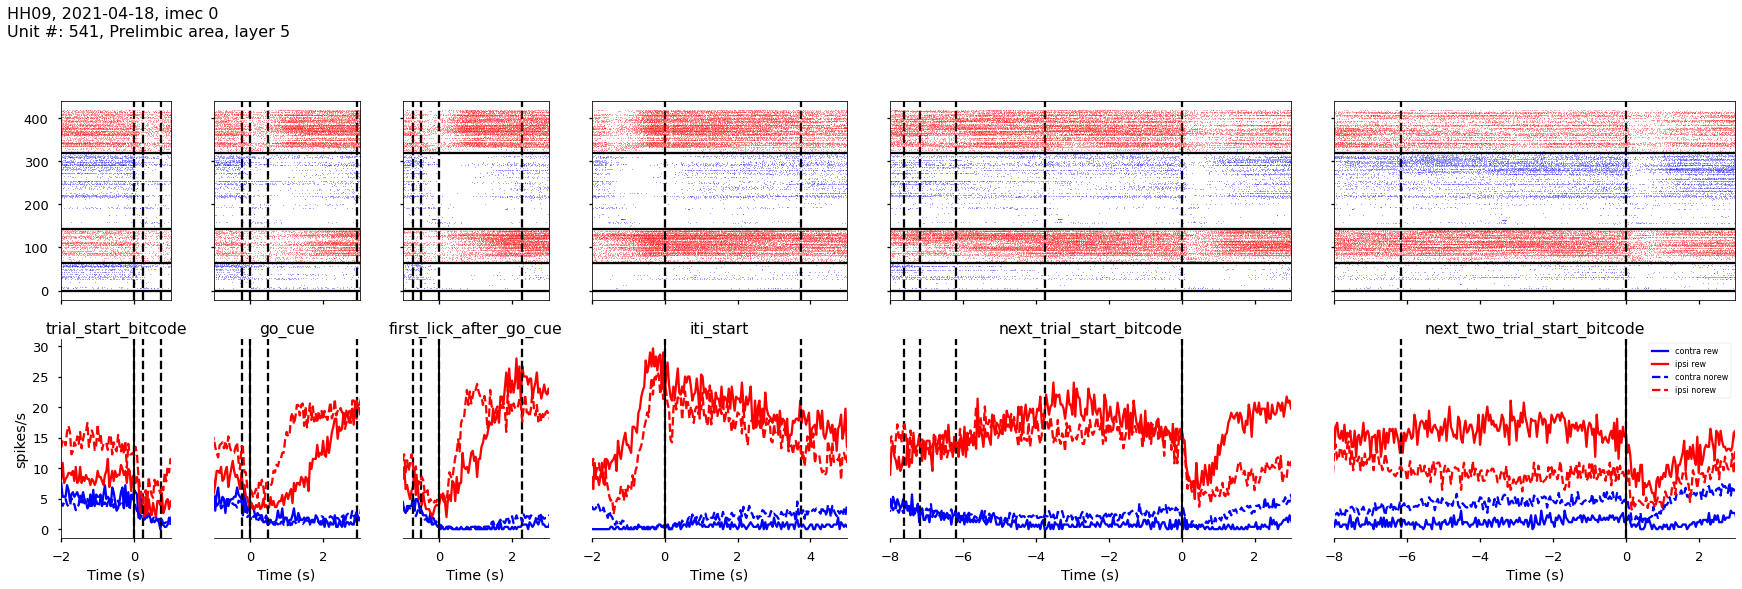

In [107]:
_ = unit_psth.plot_unit_psth_choice_outcome(unit_key, align_types)

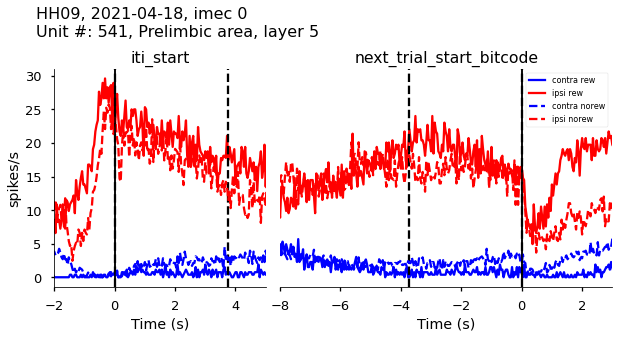

In [108]:
_ = unit_psth.plot_unit_psth_choice_outcome(unit_key, align_types=['iti_start', 'next_trial_start'], if_raster=False)

### PSTH grouped by value quantiles

In [53]:
from pipeline import foraging_model

In [76]:
(foraging_model.FittedSessionModel.proj('aic', 'bic', 'prediction_accuracy', 'cross_valid_accuracy_test') * foraging_model.Model.proj('model_notation') & unit_key).fetch(format='frame', order_by='bic')

aic      bic  prediction_accuracy  \
subject_id session model_id                                          
473361     47      10        447.544  459.672             0.714964   
                   16        442.016  462.229             0.736342   
                   11        442.626  462.840             0.738717   
                   12        449.898  466.068             0.712589   
                   18        444.148  468.404             0.736342   
                   14        448.617  468.831             0.717340   
                   17        444.319  472.617             0.752969   
                   20        445.157  473.455             0.741093   
                   3         465.582  473.667             0.733967   
                   21        450.691  474.947             0.736342   
                   7         458.955  475.125             0.729216   
                   4         463.321  479.491             0.743468   
                   5         468.248  480.376             0.733967   
                   15        460.573  480.786             0.736342   
                   19        460.972  485.228             0.729216   
                   0         504.361  512.446             0.719715   
                   9         503.416  515.544             0.688836   
                   13        500.155  516.325             0.695962   
                   1         530.735  538.820             0.679335   
                   8         527.155  539.283             0.629454   
                   2         543.521  551.606             0.629454   
                   6         545.011  557.139             0.629454   

                             cross_valid_accuracy_test  \
subject_id session model_id                              
473361     47      10                         0.712638   
                   16                         0.729181   
                   11                         0.726867   
                   12                         0.681720   
                   18                         0.712537   
                   14                         0.705473   
                   17                         0.757764   
                   20                         0.738693   
                   3                          0.733988   
                   21                         0.719713   
                   7                          0.726890   
                   4                          0.726822   
                   5                          0.733988   
                   15                         0.710201   
                   19                         0.700655   
                   0                          0.719725   
                   9                          0.672128   
                   13                         0.691266   
                   1                          0.629598   
                   8                          0.622455   
                   2                          0.629497   
                   6                          0.629361   

                                                                model_notation  
subject_id session model_id                                                     
473361     47      10                  LNP_softmax ($\tau_1$, $\sigma$, $b_L$)  
                   16        LNP_softmax_CK ($\tau_1$, $\sigma$, $b_L$, $\a...  
                   11        LNP_softmax ($\tau_1$, $\tau_2$, $w_{\tau_1}$,...  
                   12           Bari2019 ($\alpha$, $\delta$, $\sigma$, $b_L$)  
                   18        Bari2019_CK ($\alpha$, $\delta$, $\sigma$, $b_...  
                   14        Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $...  
                   17        LNP_softmax_CK ($\tau_1$, $\tau_2$, $w_{\tau_1...  
                   20        Hattori2019_CK ($\alpha_{rew}$, $\alpha_{unr}$...  
                   3                          LNP_softmax ($\tau_1$, $\sigma$)  
                   21        Hattori2019_CK ($\alpha_{rew}$, $\alpha

In [136]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

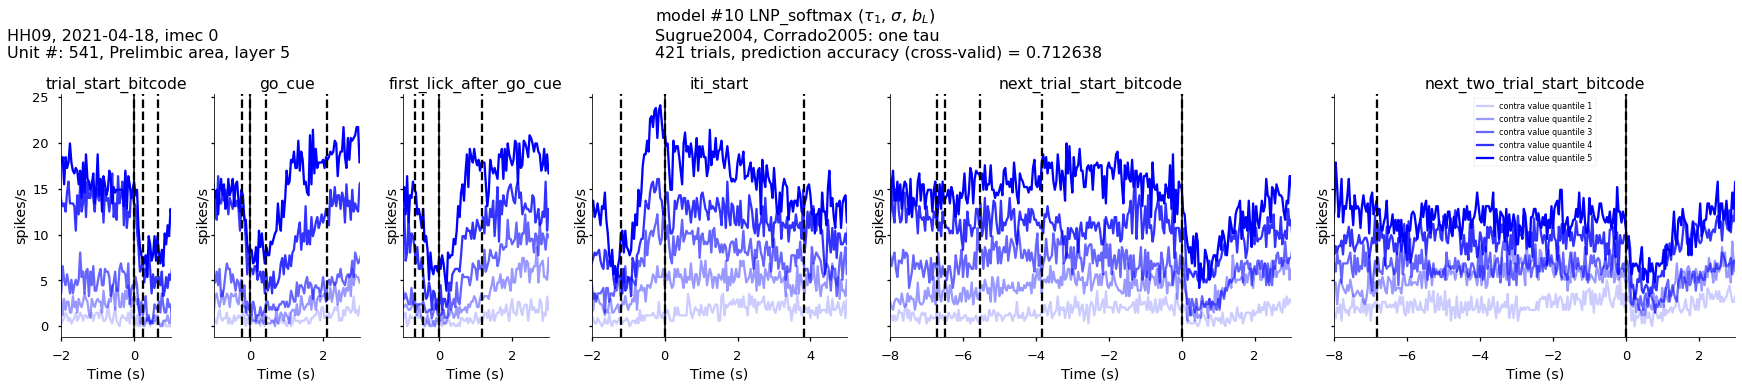

In [110]:
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10, align_types=align_types)

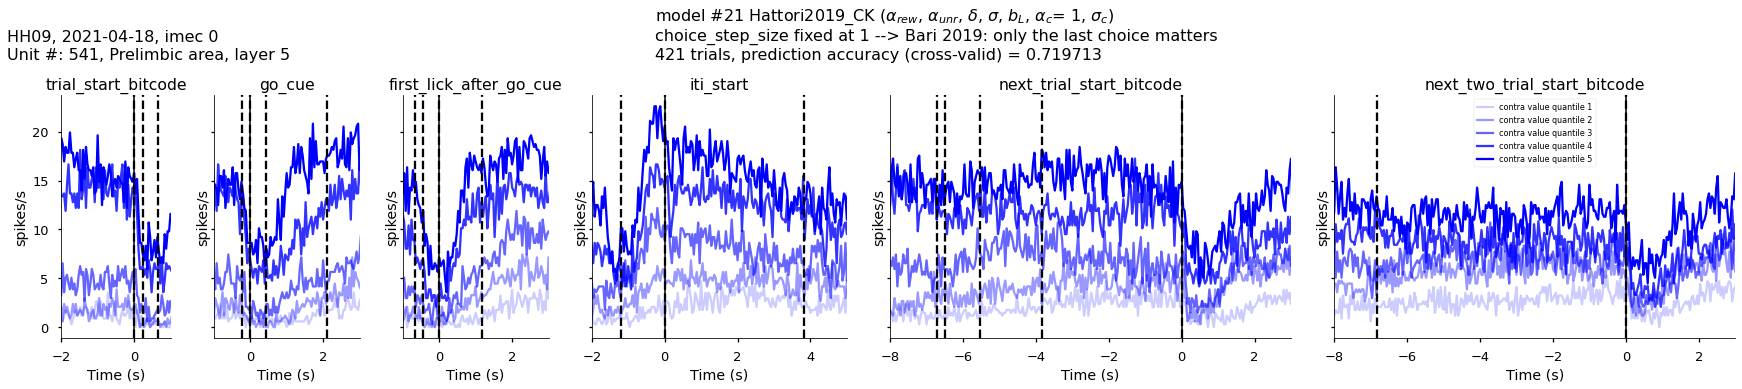

In [111]:
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=21, align_types=align_types)

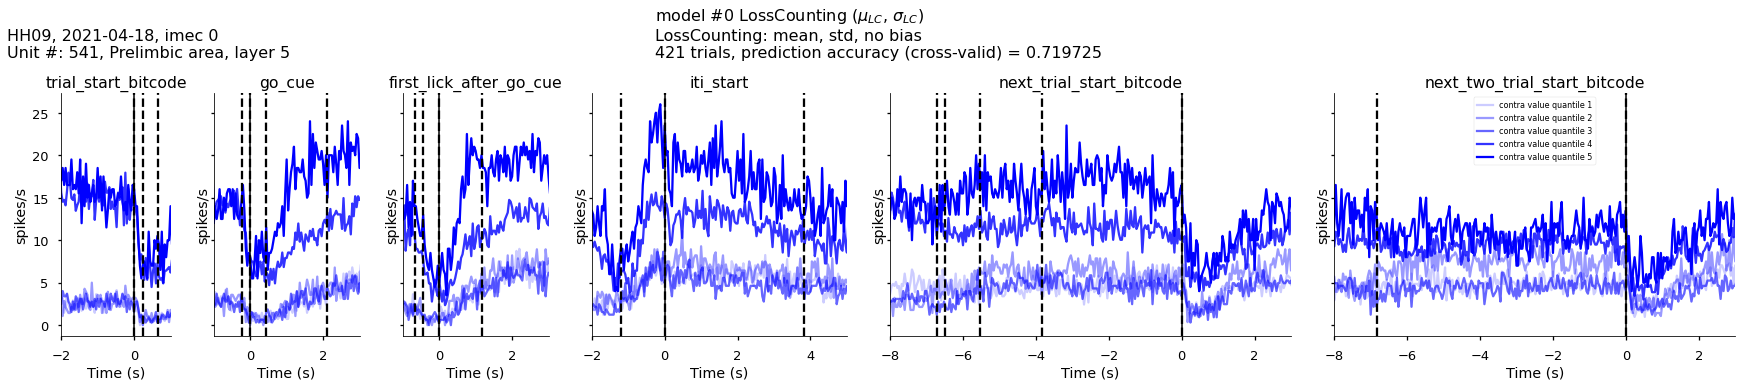

In [137]:
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=0, align_types=align_types)

In [ ]:
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=1)

### More example neurons

####  PL

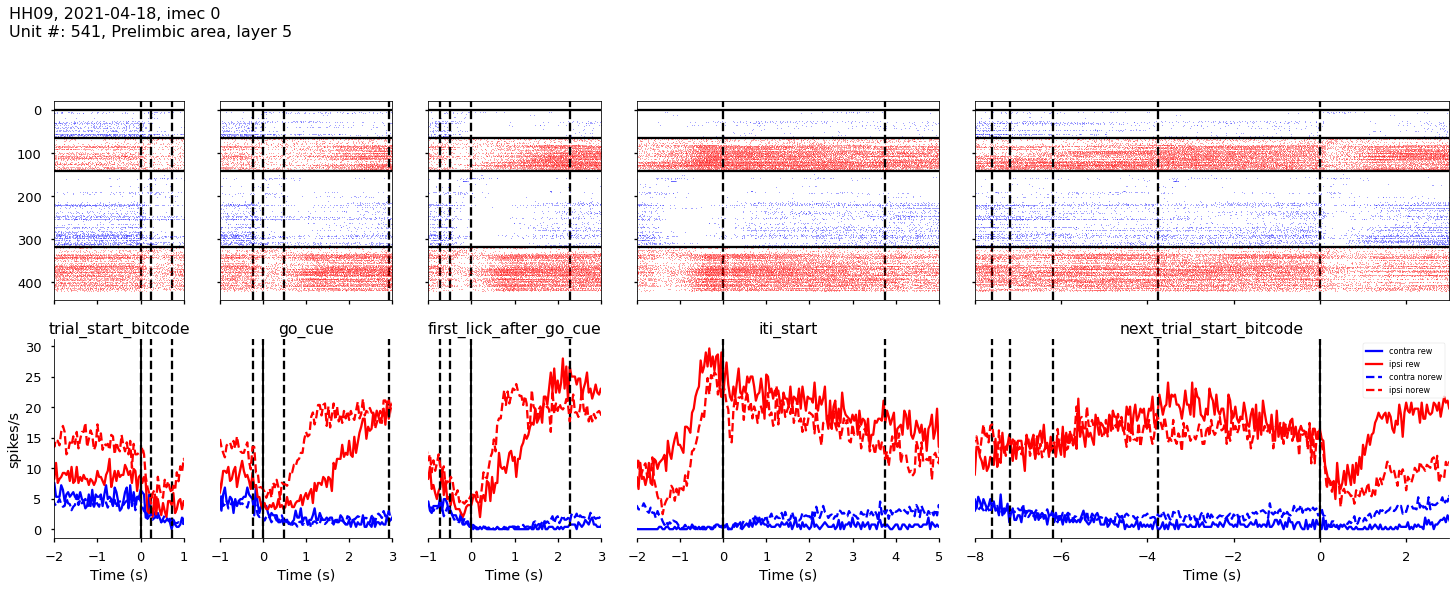

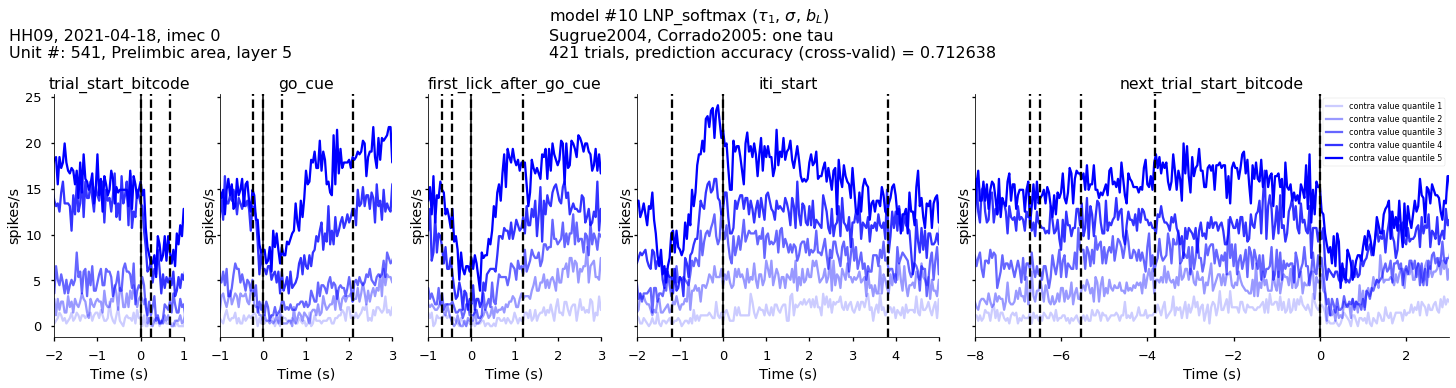

In [132]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

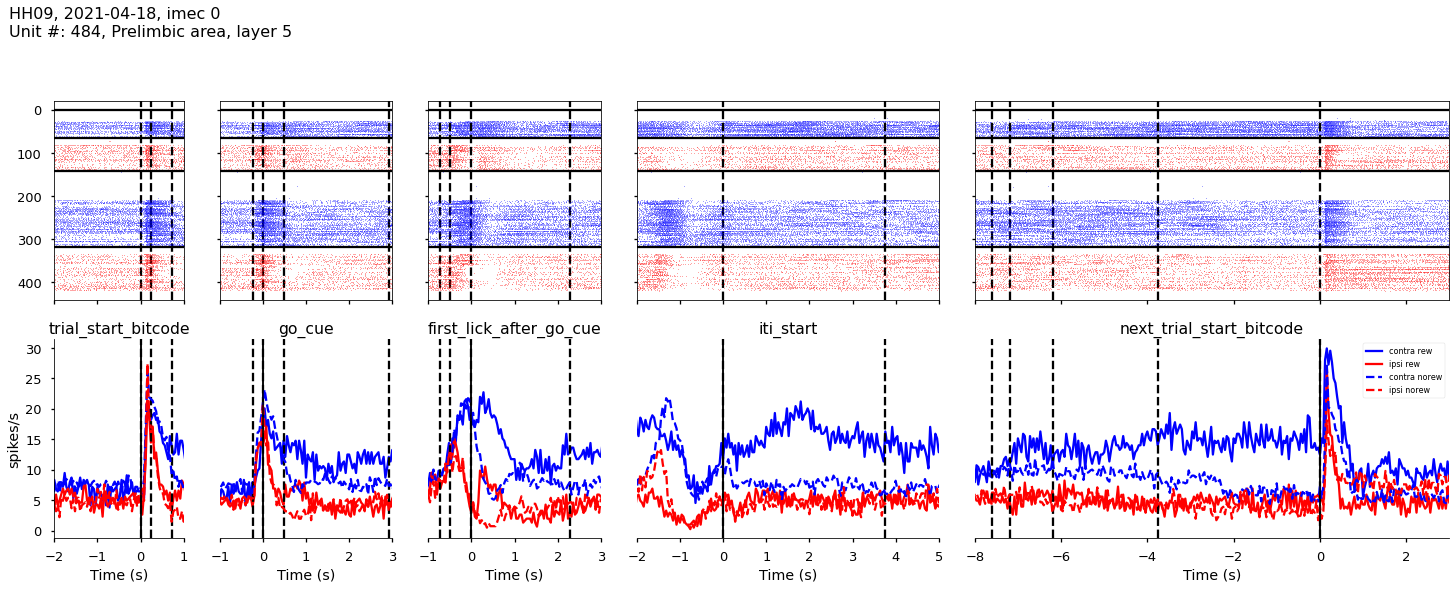

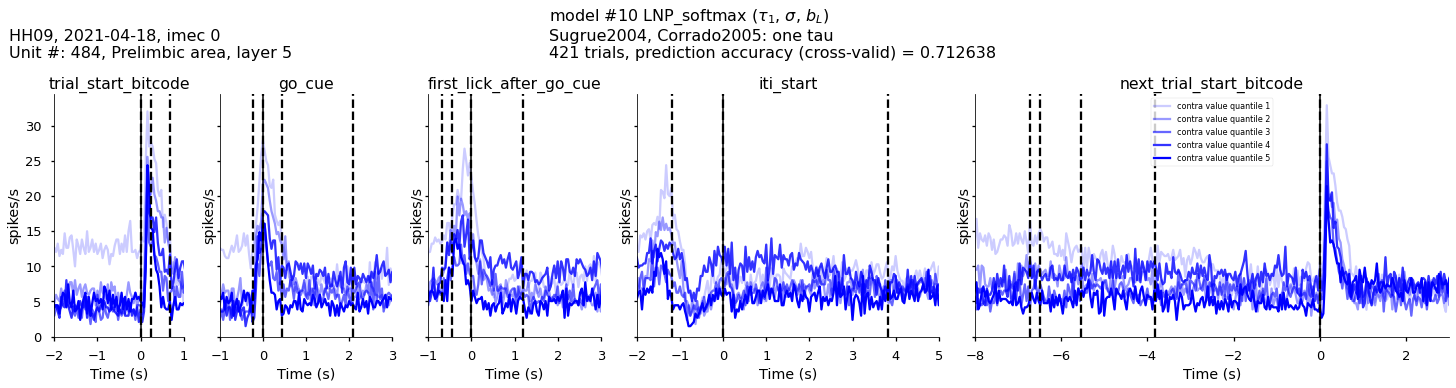

In [118]:
date, imec, unit = '2021-04-18', 0, 484
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

#### ALM

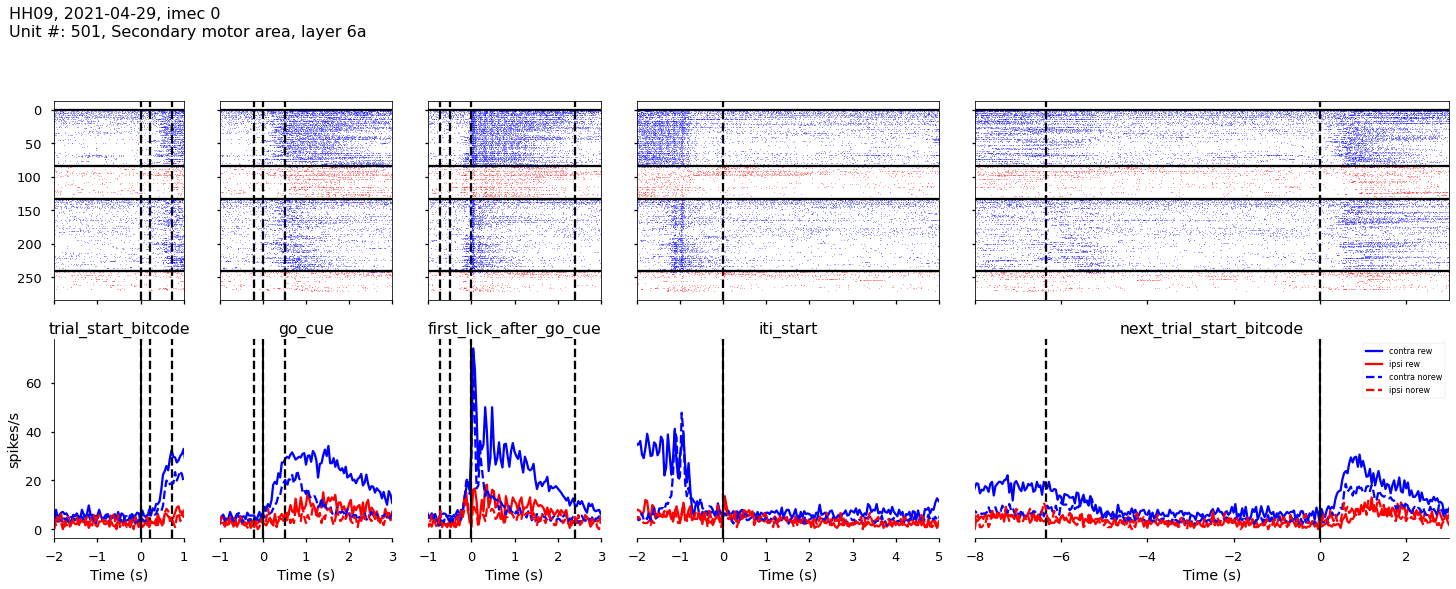

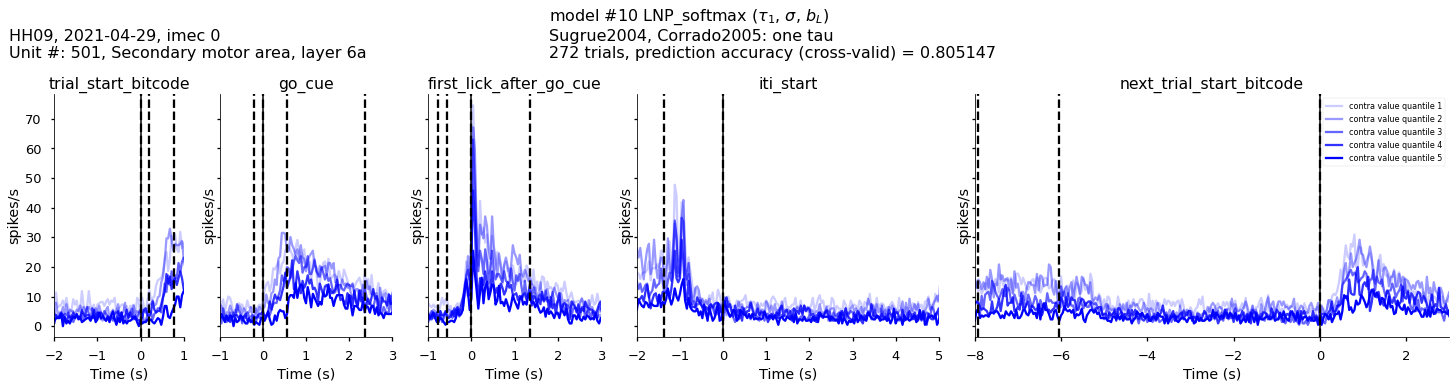

In [116]:
date, imec, unit = '2021-04-29', 0, 501
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

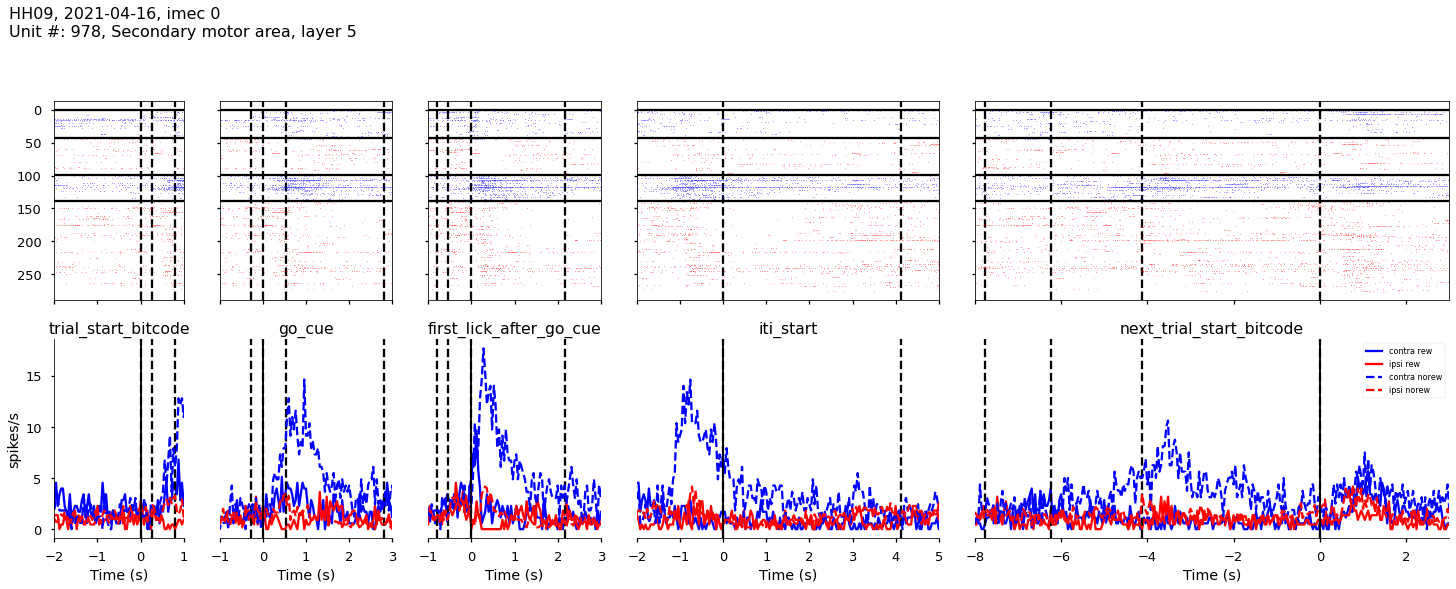

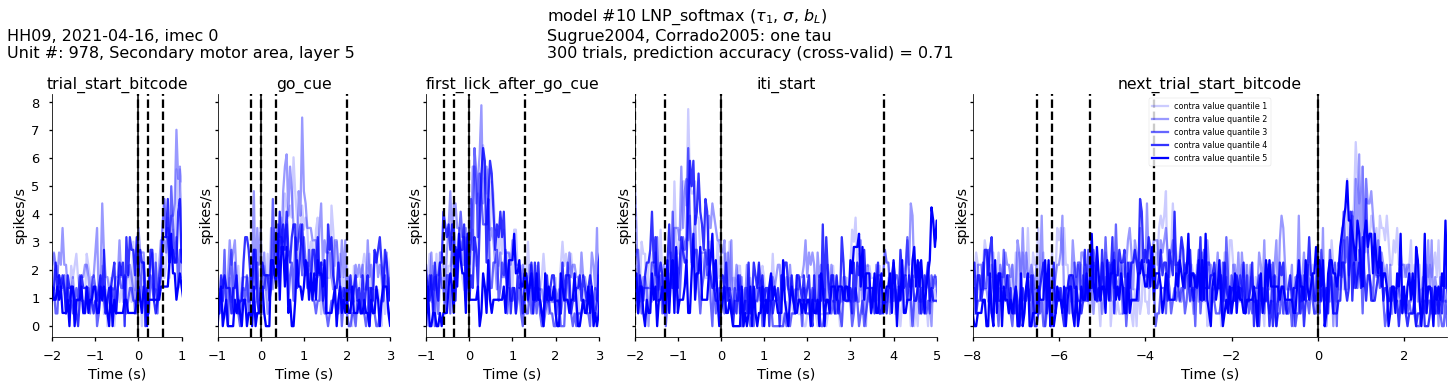

In [119]:
date, imec, unit = '2021-04-16', 0, 978
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

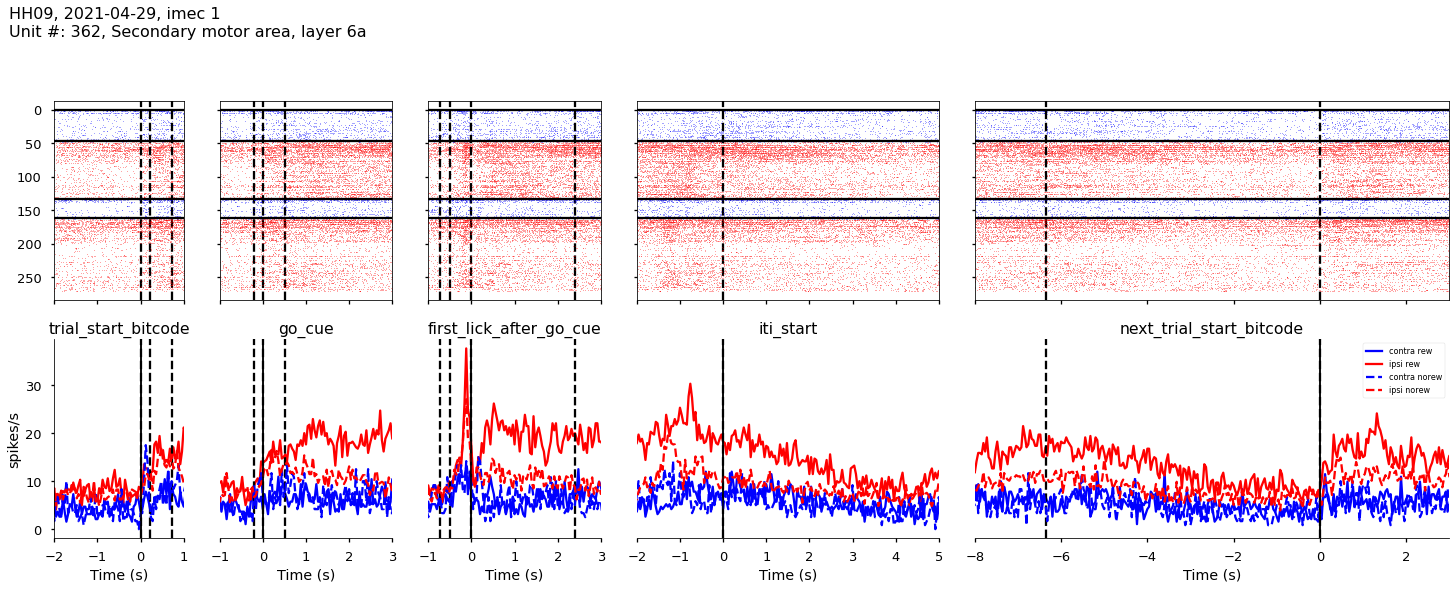

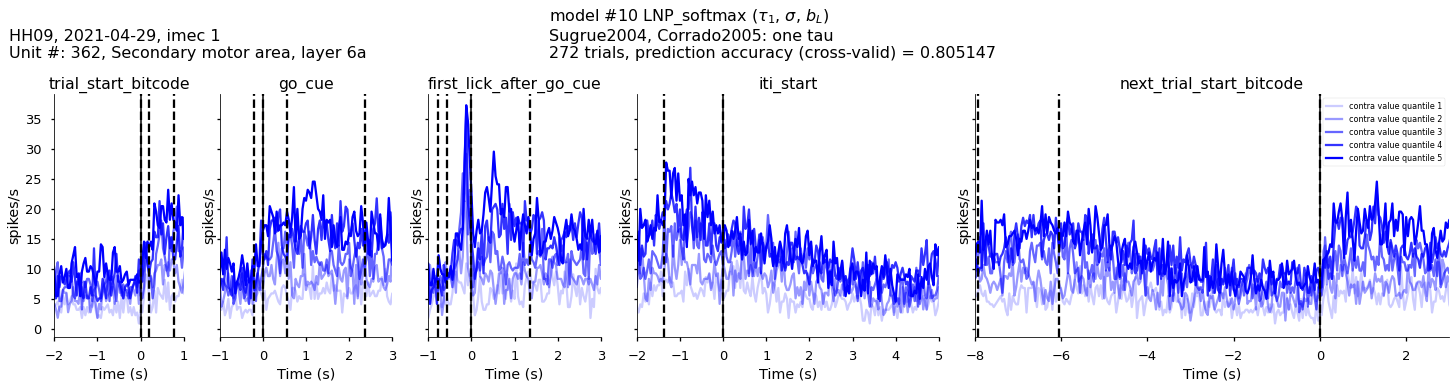

In [131]:
date, imec, unit = '2021-04-29', 1, 362
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

#### Thalamus

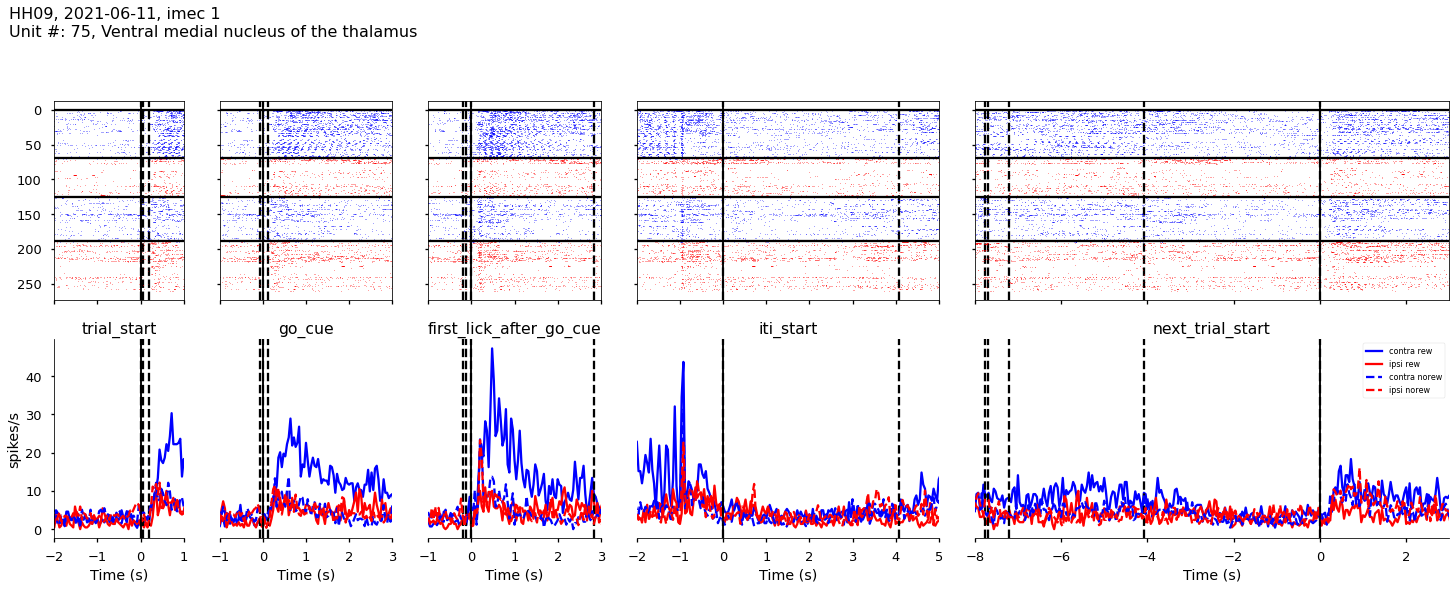

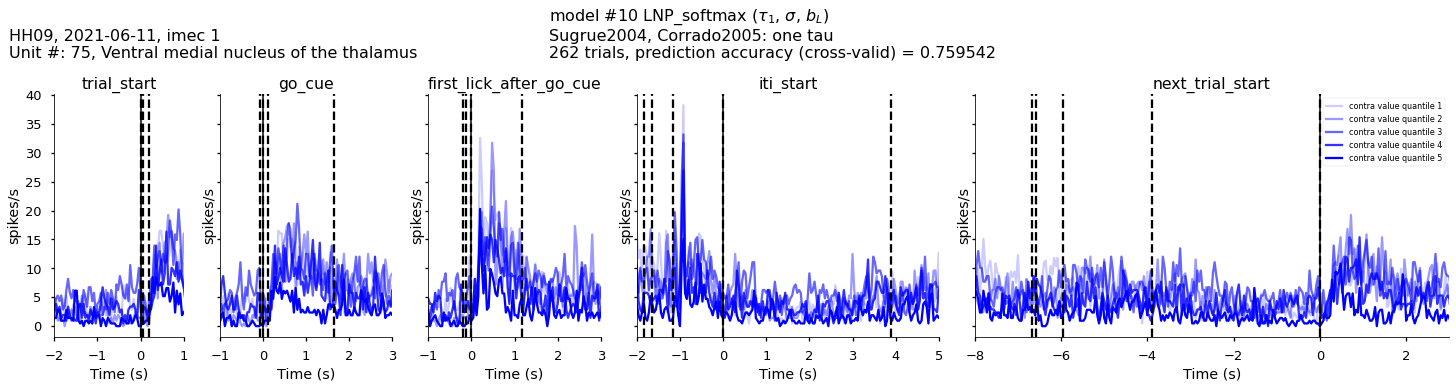

In [134]:
date, imec, unit = '2021-06-11', 1, 75
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

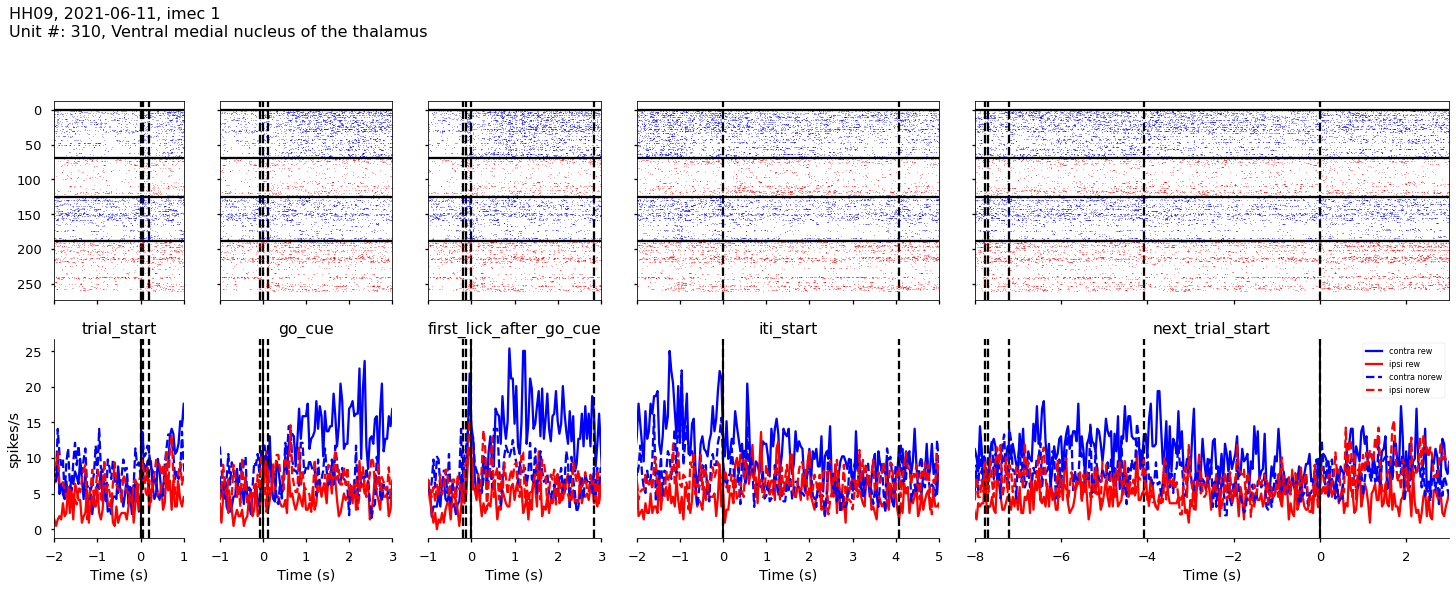

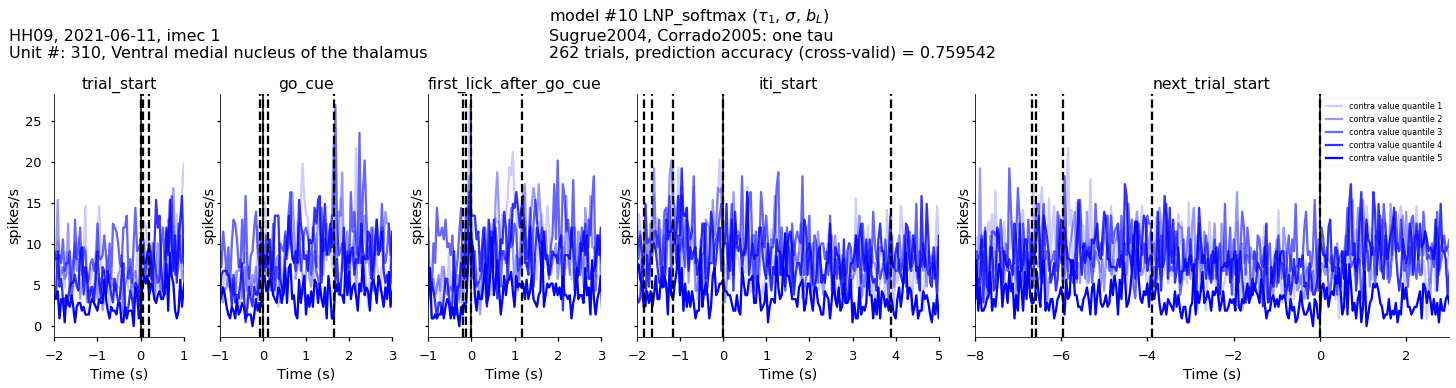

In [127]:
date, imec, unit = '2021-06-11', 1, 310
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

#### Striatum

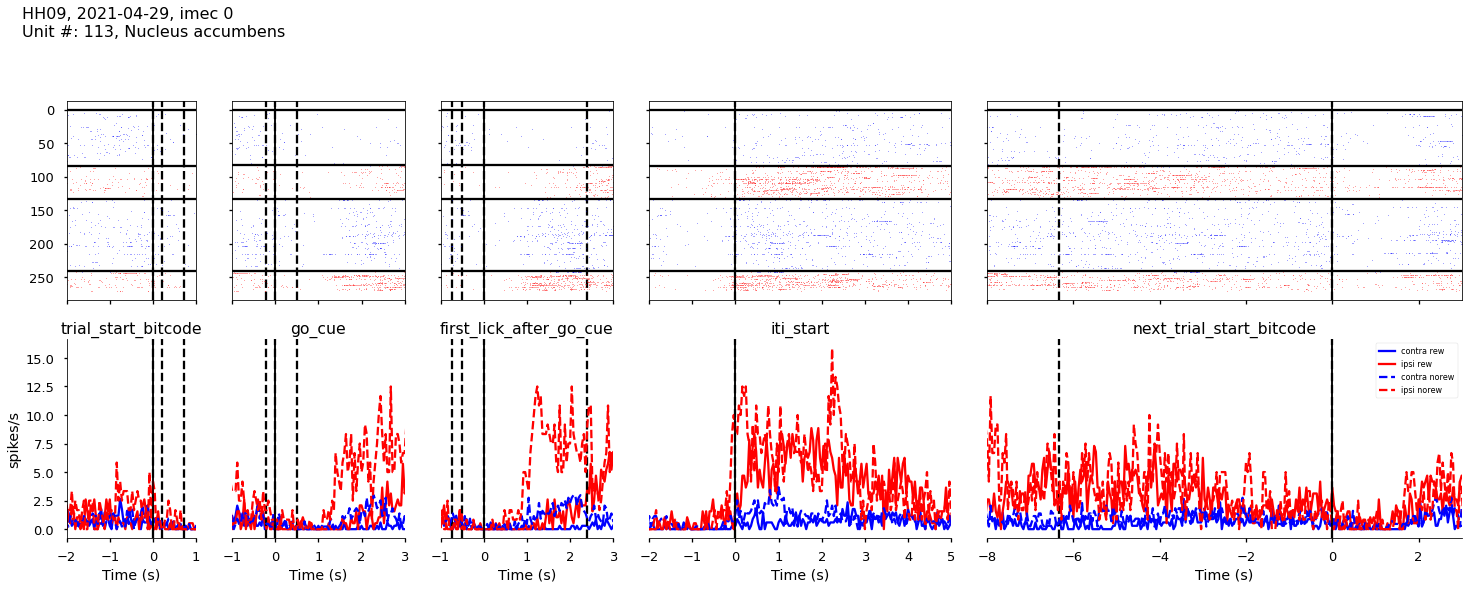

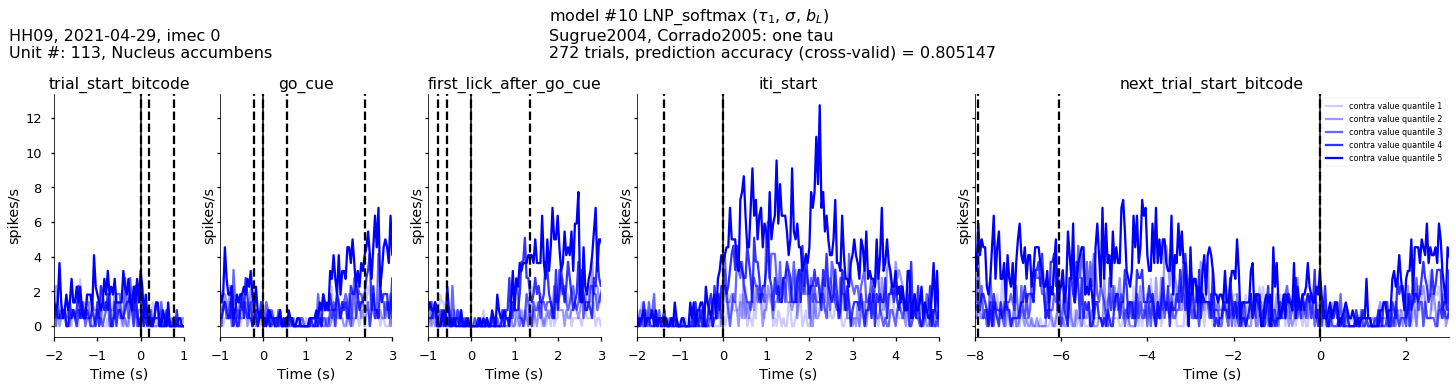

In [4]:
date, imec, unit = '2021-04-29', 0, 113
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

####  Midbrain

These two should be in VTA

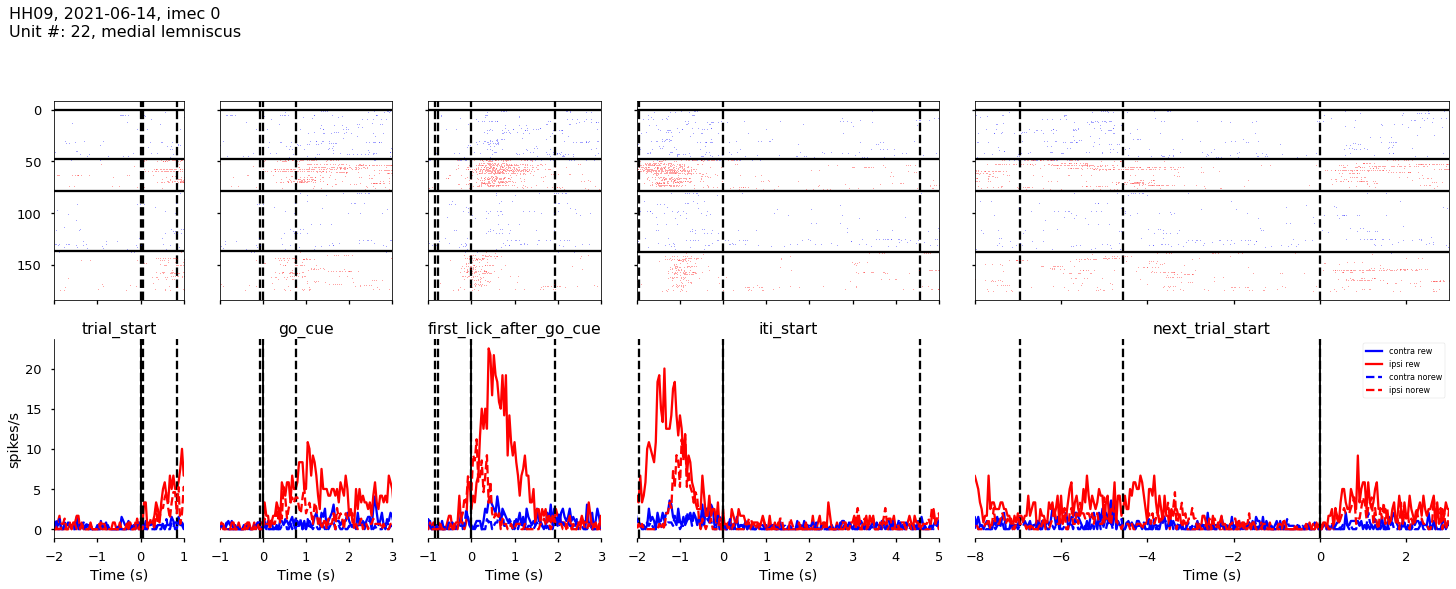

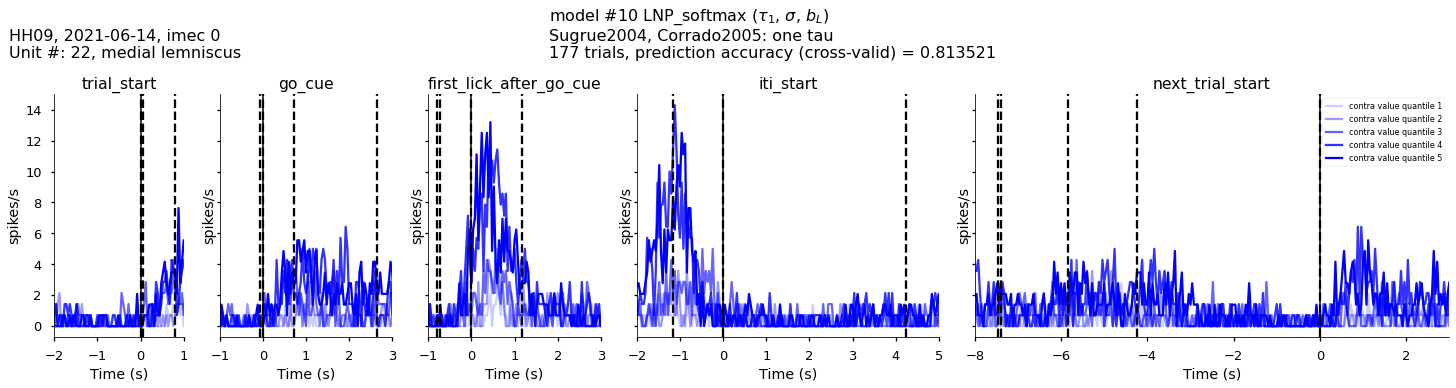

In [129]:
date, imec, unit = '2021-06-14', 0, 22
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

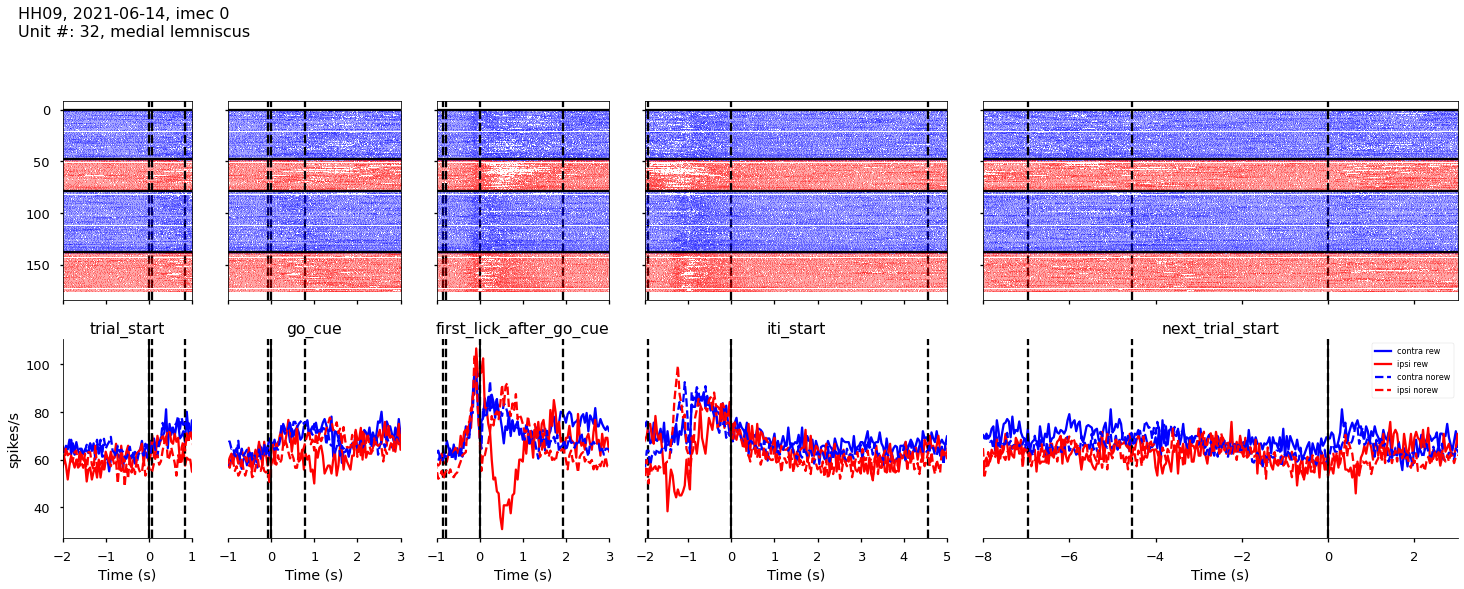

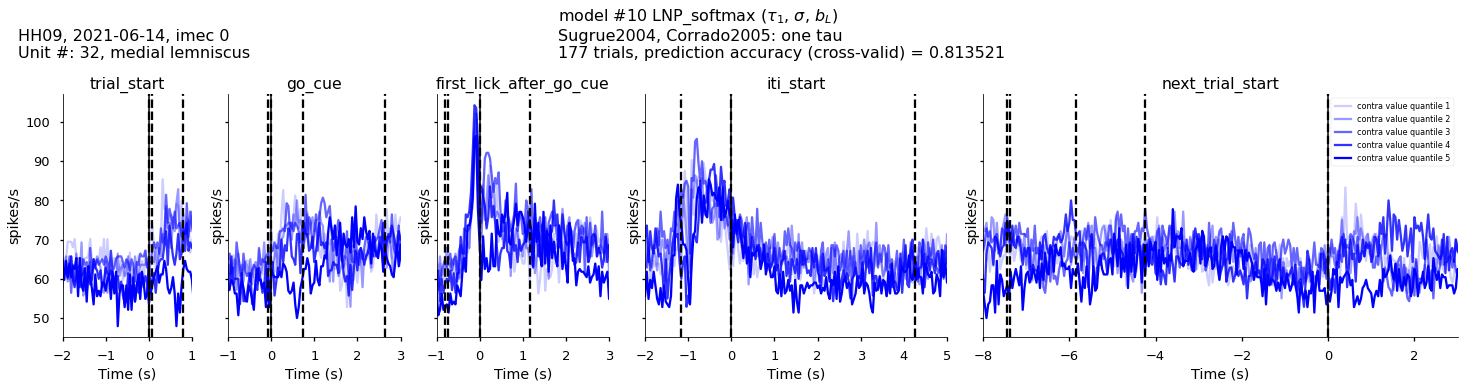

In [130]:
date, imec, unit = '2021-06-14', 0, 32
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

#### Ventral Pallidum

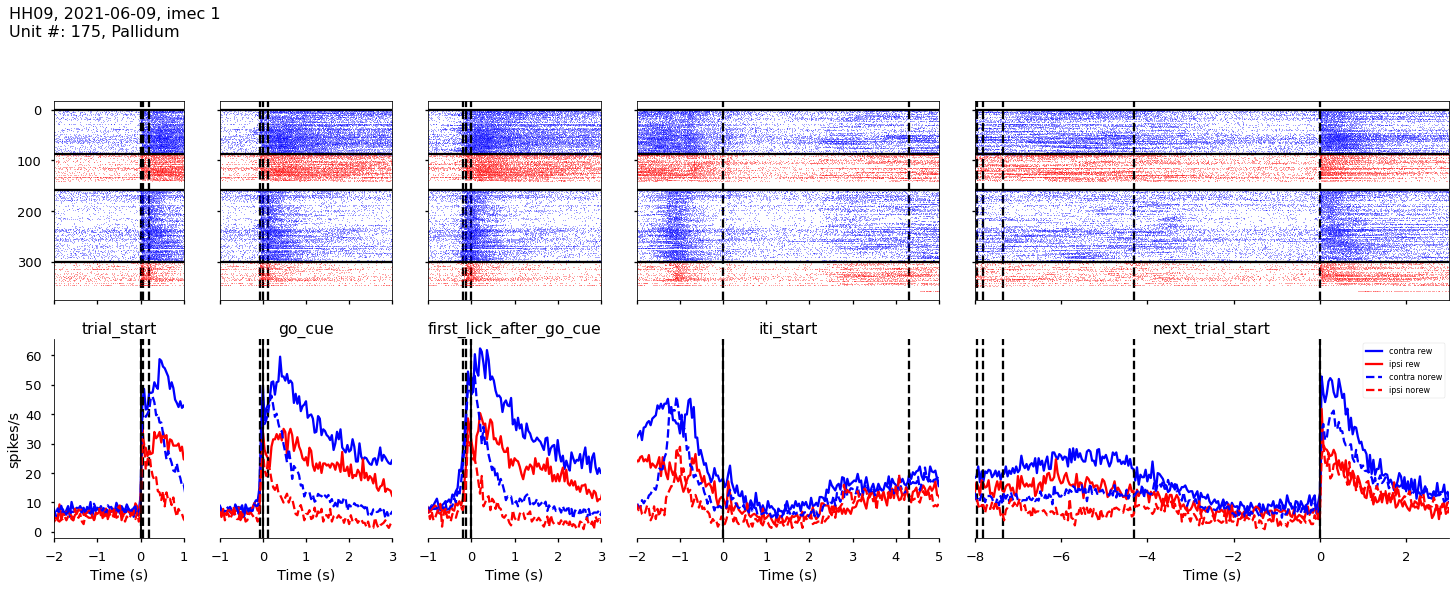

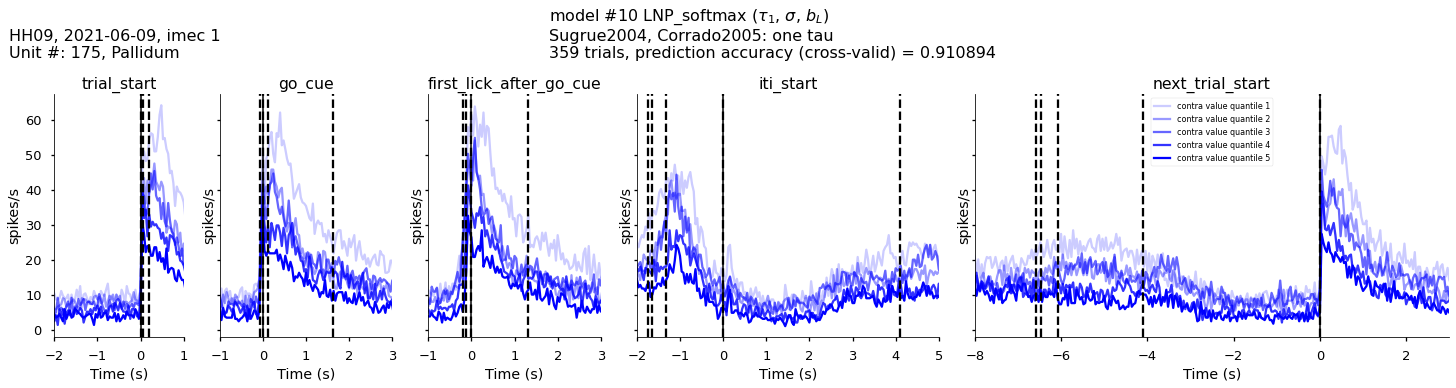

In [122]:
date, imec, unit = '2021-06-09', 1, 175
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

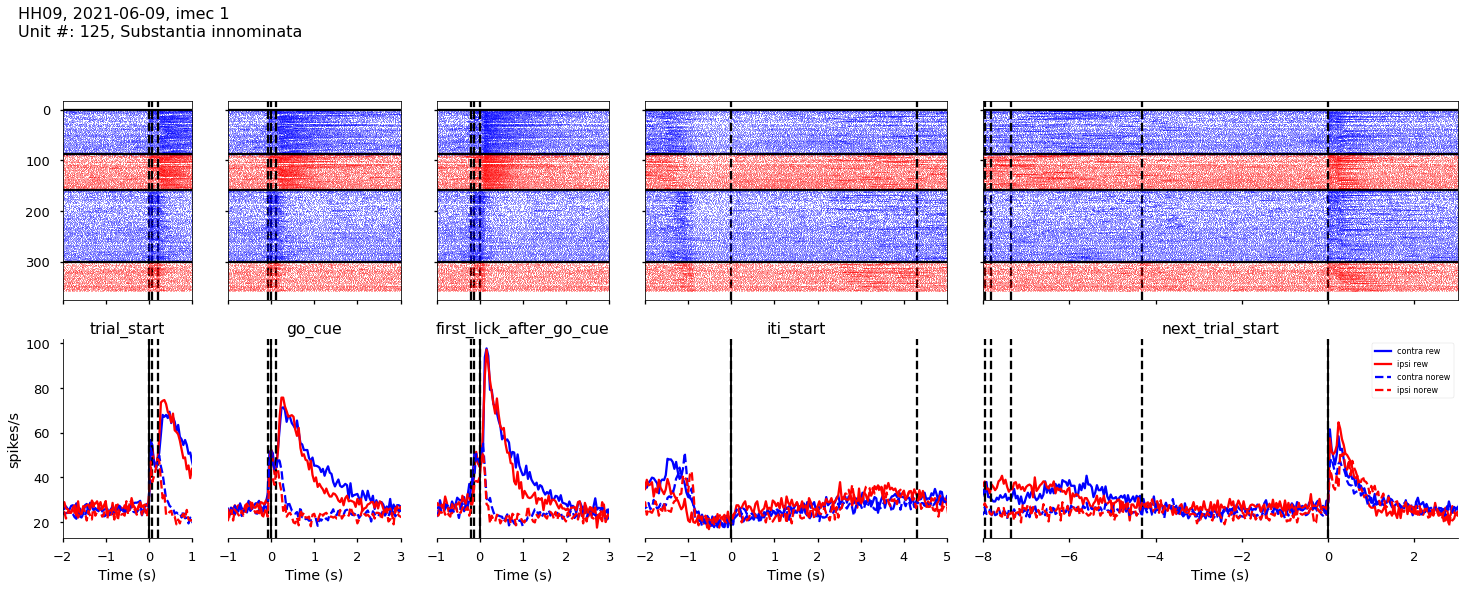

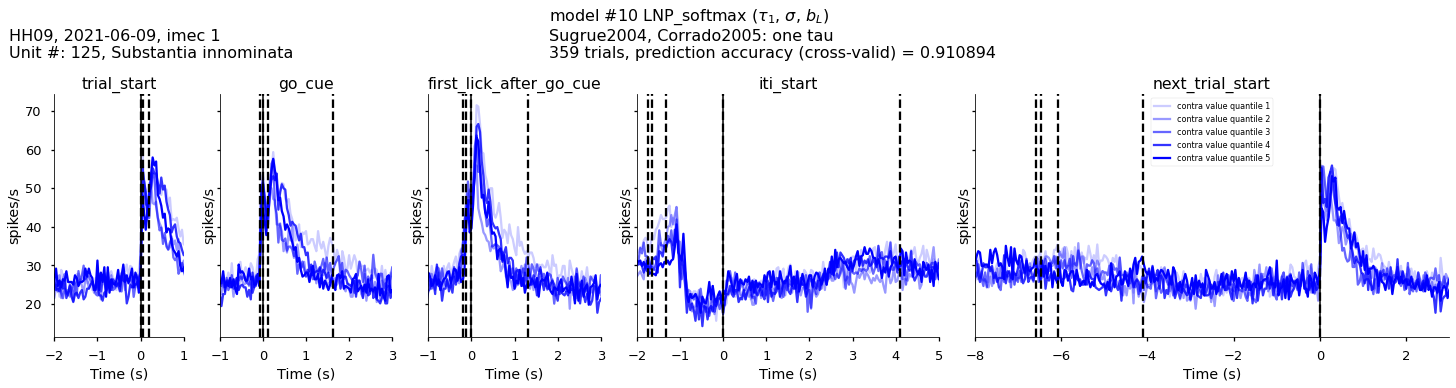

In [133]:
date, imec, unit = '2021-06-09', 1, 125
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

#### RSC

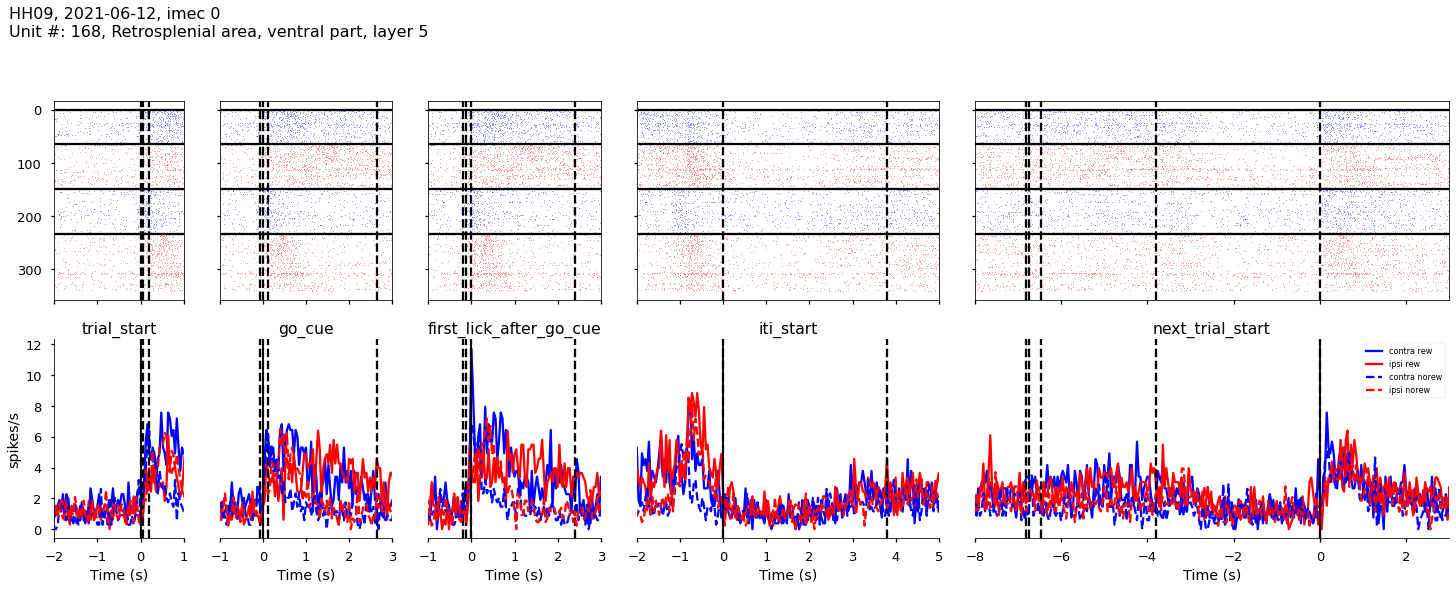

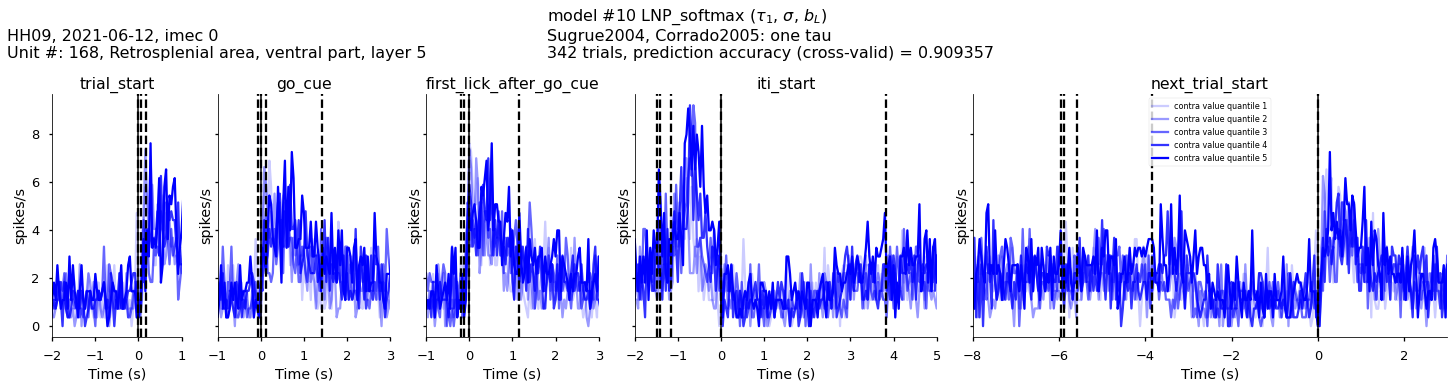

In [128]:
date, imec, unit = '2021-06-12', 0, 168
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

#### OFC

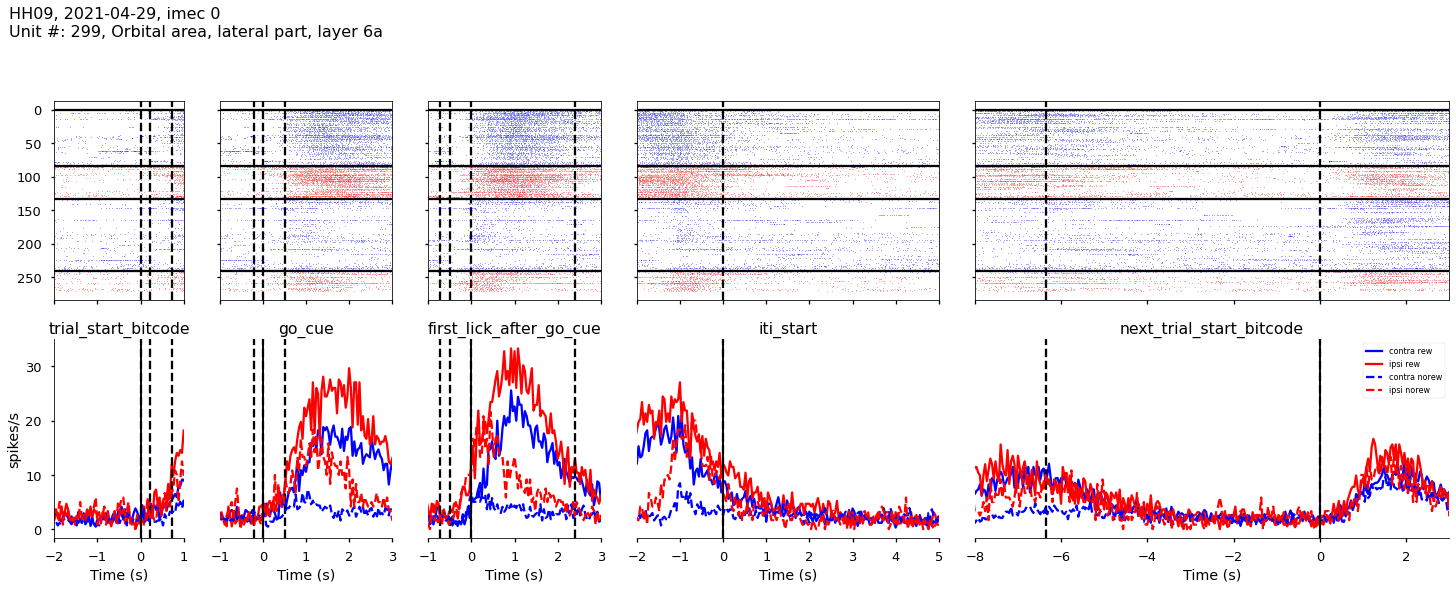

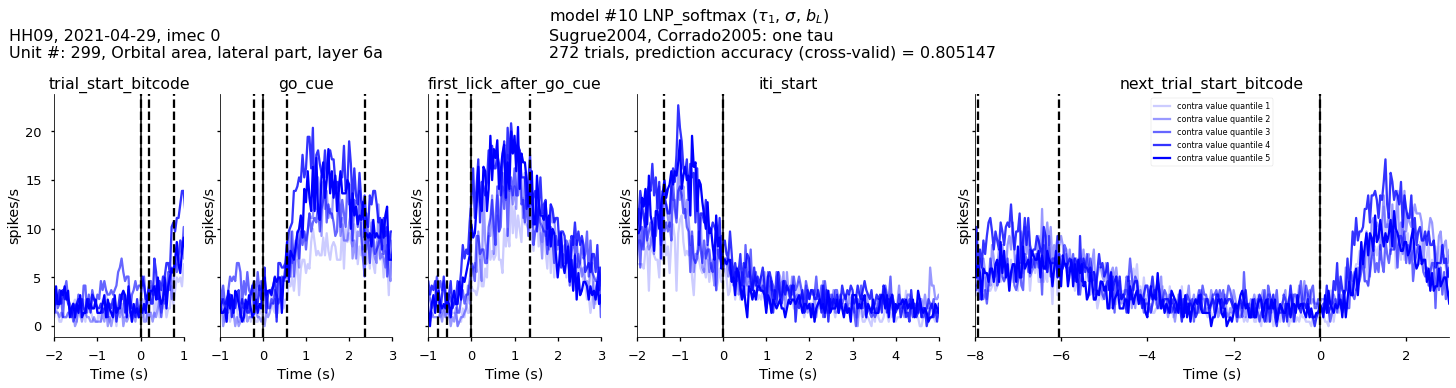

In [120]:
date, imec, unit = '2021-04-29', 0, 299
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_value_quantile(unit_key, model_id=10)

# Trial Number issue

Retrieve the original bpod files for a certain session.

In [ ]:
from pipeline.ingest.behavior import BehaviorBpodIngest
BehaviorBpodIngest.BehaviorFile() * experiment.Session() * lab.WaterRestriction.proj('water_restriction_number') & 'session_date = "2021-04-18"'

The potential bug of having the same bitcode because of the fixed rand seed.

In [ ]:
experiment.TrialNote & 'trial_note = "01000110111010000110"'

In [ ]:
dj.ERD(ephys)

# Timing issue

In [ ]:
from pipeline.ingest.util import compare_ni_and_bpod_times

In [ ]:
compare_ni_and_bpod_times()

# Code cache

In [ ]:
experiment.Session & 'session = 35' & 'subject_id = 473361'

In [ ]:
experiment.TrialEvent()


In [ ]:
behavior_ingest.BehaviorBpodIngest.BehaviorFile.key_source()

Histology ingest

In [ ]:
(histology.ElectrodeCCFPosition * experiment.Session) & \
(lab.WaterRestriction  & 'water_restriction_number = "SC045"')

In [ ]:
(histology.ElectrodeCCFPosition * experiment.Session) & \
(lab.WaterRestriction  & 'water_restriction_number = "SC050"')